### Set up your local Dask cluster.

So as long as you have the Dask extension installed and enabled, there should be a little Dask icon on the left below the stop icon.

**Option 1:** Click `+NEW` cluster. Then you can drag and drop the cluster directly into your notebook or copy and paste the new Scheduler Address into the argument for the Client below.

**Option 2:** You can start a cluster in the notebook using specific number of workers and memory arguments. If you do this, then you will need to copy and paste the scheduler address on the dask taskbar to show widgets related to that cluster. 

Once the cluster is started and connected to the Notebook, I like to open the Dask Graph and Progress tabs.

In [1]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:33041")
# client

In [2]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colorbar import Colorbar # different way to handle colorbar
# plot styles/formatting
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# Extra 
import wrf
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from xarrayMannKendall import *
from plotter import draw_basemap, make_cmap, add_subregion_boxes
from timeseries import select_months_ds



In [3]:
# Set up paths

path_to_data = '/scratch1/08540/dlnash/data/'     # project data -- read only
path_to_data = '/work2/08540/dlnash/frontera/data/wrf_preprocessed_data/wrf_6km/' # WORK directory
path_to_data = '/home/nash/DATA/data/wrf_hasia/' # great
path_to_out  = '../out/'                          # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'                         # figures


In [4]:
ssn = "MAM" #"MAM" or "DJF"

if ssn == 'DJF':
    start_date = '1979-12-01'
    end_date = '2015-03-31'
    mon_s = 12
    mon_e = 2
    mon_lst = [12, 1, 2]
    plt_lst = ['(a) December', '(b) January', '(c) February']
    
if ssn == 'MAM':
    start_date = '1980-03-01'
    end_date = '2014-05-31'
    mon_s = 3
    mon_e = 5
    mon_lst = [3, 4, 5]
    plt_lst = ['(a) March', '(b) April', '(c) May']

lonmin = 61.
lonmax = 98.
latmin = 22.
latmax = 56.

# subregion info for ar type precip anomalies
ext1 = [69, 74, 37, 40] # Northwestern precip anomalies
ext2 = [71, 79, 32, 37] # Western precip anomalies
ext3 = [90, 99, 24, 30] # Eastern precip anomalies
domains = [ext1, ext2, ext3]
region_name = ['NW', 'W', 'E']

# domain extent info 
# [xmin, ymin]
sr_xy = []
sr_width = []
sr_height = []

for i, d in enumerate(domains):
    sr_xy.append([d[0], d[2]])
    sr_width.append((d[1] - d[0]))
    sr_height.append((d[3]- d[2]))


In [5]:
def combine_ar_ds_df(ds, df):
    # Combine AR Cat data w/ WRF data
    # Add ar time series to the WRF dataset
    ds['ar'] = ('time', df.AR_CAT)
    ds = ds.set_coords('ar')

    ds['trackID'] = ('time', df.kidmap)
    ds = ds.set_coords('trackID')
    idx = (ds.ar >= 1)
    # select AR days
    ds_ar = ds.sel(time=idx)
    return ds_ar

def compute_MK_trend_da(da):
    # rename coords lat,lon to y,x because that is what the function needs
    da = da.rename({'lat': 'y', 'lon': 'x'})

    # rechunk dask version of data so it is a single chunk
    da_new = da.chunk({'time': -1})
    # # load data since since it can fit into memory
    da_new = da_new.load()
    
    # Compute trends using Mann-Kendall test - takes roughly 2 seconds!
    MK_class = Mann_Kendall_test(da_new, 'time')
    MK_class = MK_class.compute() 
    return MK_class

### Load WRF data

In [6]:
# get terrain height from one wrf file
wrf_filename = "/work2/08540/dlnash/frontera/data/wrf_norris/20211113_case/wrfout_d01_2010-02-04_03:00:00"
wrf_filename = "/home/hasia/2009/wrfout_d01_2010-02-04_03:00:00"
wrfin = nc.Dataset(wrf_filename)
ter = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height

In [7]:
varname = 'ivt'
domain = 'd01'

filename_pattern = path_to_data + '{0}/{1}/daily/out.wrf6km.{1}.daily_*.nc'.format(domain, varname)
print(filename_pattern)
ds = xr.open_mfdataset(filename_pattern)
ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
ds


/home/nash/DATA/data/wrf_hasia/d01/ivt/daily/out.wrf6km.ivt.daily_*.nc


<xarray.Dataset>
Dimensions:  (time: 12906, lat: 249, lon: 259)
Coordinates:
  * time     (time) datetime64[ns] 1979-11-30 1979-12-01 ... 2015-03-31
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
Data variables:
    ivtu     (time, lat, lon) float64 dask.array<chunksize=(32, 249, 259), meta=np.ndarray>
    ivtv     (time, lat, lon) float64 dask.array<chunksize=(32, 249, 259), meta=np.ndarray>
    iwv      (time, lat, lon) float64 dask.array<chunksize=(32, 249, 259), meta=np.ndarray>
    ivt      (time, lat, lon) float64 dask.array<chunksize=(32, 249, 259), meta=np.ndarray>

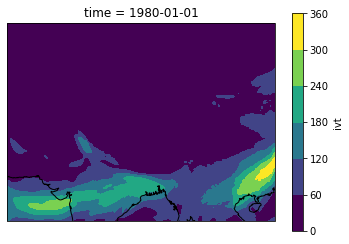

In [8]:
## test plot 1 time step of daily data
ax = plt.axes(projection=ccrs.PlateCarree())

ds.ivt.sel(time='1980-01-01').plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

### Average height of IVT during each month of winter season (climatology)

In [9]:
# get monthly climatology
ds_clim = ds.groupby("time.month").mean('time')
ds_clim

# get ssn clim
ssn_clim = ds_clim.sel(month=mon_lst).mean('month')
ssn_clim

<xarray.Dataset>
Dimensions:  (lat: 249, lon: 259)
Coordinates:
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
Data variables:
    ivtu     (lat, lon) float64 dask.array<chunksize=(249, 259), meta=np.ndarray>
    ivtv     (lat, lon) float64 dask.array<chunksize=(249, 259), meta=np.ndarray>
    iwv      (lat, lon) float64 dask.array<chunksize=(249, 259), meta=np.ndarray>
    ivt      (lat, lon) float64 dask.array<chunksize=(249, 259), meta=np.ndarray>

### Calculate Anomalies

In [10]:
%%time

## load filtered annual climatology
clim_mean = xr.open_dataset(path_to_data + 'd01/ivt/filtered_daily_mean_clim_ivt.nc')
clim_mean = clim_mean.assign(ivt=lambda clim_mean: np.sqrt(clim_mean.ivtu**2 + clim_mean.ivtv**2))

## Calculate Anomalies
anomalies_daily = ds.groupby('time.dayofyear') - clim_mean

# resample anomalies to monthly
anomalies_mon = anomalies_daily.resample(time="1MS").mean('time')

CPU times: user 50.1 s, sys: 48.4 s, total: 1min 38s
Wall time: 1min 38s


## Plot Monthly Climatology

In [11]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+5,5)
dy = np.arange(latmin,latmax+5,5)

# hack for tick labels
share_right = [False]*2 + [True]

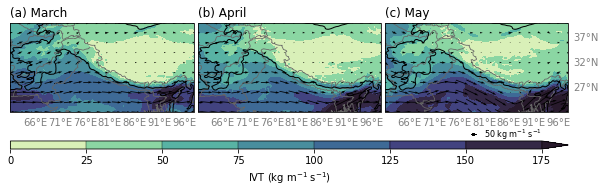

In [12]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='3%',label_mode='',
                direction='row')

# Loop for drawing each plot
for k, (ax, mon) in enumerate(zip(axgr, mon_lst)):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k])
    # Data for plotting
    data = ds_clim.ivt.sel(month=mon)
    uvec = ds_clim.ivtu.sel(month=mon).values
    vvec = ds_clim.ivtv.sel(month=mon).values
    lons = data.lon.values
    lats = data.lat.values
    
    # cmap setup
    cmap = cmo.deep
    cflevs = np.arange(0, 200, 25)

    # Contour Filled
    cf = ax.contourf(lons, lats, data.values, transform=datacrs,
                    levels=cflevs,cmap=cmap, extend='max')
    
    # Wind barbs / vectors
    Q = ax.quiver(data.lon.values, data.lat.values, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=10, pivot='middle',
                  angles='xy', scale_units='xy', scale=50, units='xy')
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)

    
    # Subtitles
    ax.set_title(plt_lst[k], loc='left', fontsize=12)
#     ax.annotate(plt_lst[k], (5, 237), xycoords='axes points', fontsize=12.,
#                 backgroundcolor='white')

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=10)
cb.ax.tick_params(labelsize=10)

# quiver key
qk = ax.quiverkey(Q, 0.5, -0.25, 50, '50 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})
    
# Save figure
filepath = path_to_figs + 'ivt_{0}_clim.png'.format(ssn)
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()

### Trend of IVT over 35 years

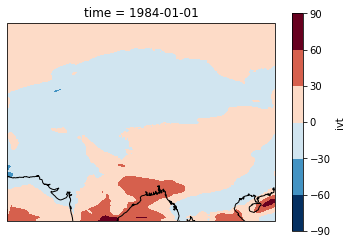

In [13]:
## test plot 1 time step of daily data
ax = plt.axes(projection=ccrs.PlateCarree())

anomalies_mon.ivt.sel(time='1984-01-01').plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [14]:
%%time

# wrf_mon = ds.resample(time="1MS").mean('time')
# anomalies_mon = anomalies_mon.load()

#### compute trend for each month
final_trend_clim = []
for i, mon in enumerate(mon_lst):
    # select single month
    idx = (anomalies_mon.time.dt.month == mon)
    da = anomalies_mon.ivt.sel(time=idx)
    trend = compute_MK_trend_da(da)
    final_trend_clim.append(trend)
    
final_trend_clim[0]

CPU times: user 10min 40s, sys: 11min 35s, total: 22min 16s
Wall time: 10min 39s


<xarray.Dataset>
Dimensions:    (y: 249, x: 259)
Coordinates:
  * x          (x) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
  * y          (y) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
Data variables:
    trend      (y, x) float64 0.07279 0.08195 0.092 ... 0.07848 0.07129 0.06679
    signif     (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    p          (y, x) float64 0.9457 0.8381 0.713 0.6728 ... 0.2699 0.3473 0.376
    std_error  (y, x) float64 0.3347 0.3308 0.327 ... 0.1518 0.1498 0.1525

## Plot Monthly Trend (all days)

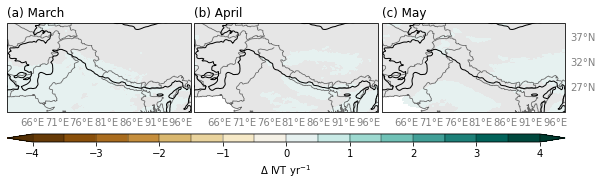

In [15]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.25, cbar_size='3%',label_mode='',
                direction='row')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k])
    # Data for plotting
    data = final_trend_clim[k].trend.values
    pval_mask = final_trend_clim[k].p.where((final_trend_clim[k].p <= 0.1)).values
    lons = final_trend_clim[k].x.values
    lats = final_trend_clim[k].y.values
    
    # Contour Filled
    cflevs = np.arange(-4., 4.5, .5)
    cf = ax.contourf(lons, lats, pval_mask, transform=datacrs,
                    levels=cflevs,cmap='BrBG', extend='both')
    
    # # Wind barbs / vectors
    # uvec_mask = data.U250.where((pval.U250 <= sig_level) | (pval.V250 <= sig_level)).values
    # vvec_mask = data.V250.where((pval.U250 <= sig_level) | (pval.V250 <= sig_level)).values
    # Q = ax.quiver(data.lon.values, data.lat.values, uvec, vvec, transform=datacrs, 
    #               color='k', regrid_shape=10, pivot='middle',
    #               angles='xy', scale_units='xy', scale=50, units='xy')
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)

    
    # Subtitles
    ax.set_title(plt_lst[k], loc='left', fontsize=12)
#     ax.annotate(plt_lst[k], (5, 237), xycoords='axes points', fontsize=12.,
#                 backgroundcolor='white')

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(r'$\Delta$ IVT yr$^{-1}$ ', fontsize=10)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs +'ivt_trend_yearly.png'
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()

### Trend of IVT over AR days DJF

#### Load AR dates and merge with daily anomalies

In [28]:
filepath = path_to_out + 'AR-types_ALLDAYS.csv'
df = pd.read_csv(filepath)

# set times as index
df = df.rename(columns={'Unnamed: 0': 'date'})
df = df.set_index(pd.to_datetime(df['date']))

# select only ssn months
if mon_s > mon_e:
    idx = (df.index.month >= mon_s) | (df.index.month <= mon_e)
if mon_s < mon_e:
    idx = (df.index.month >= mon_s) & (df.index.month <= mon_e)
df = df.loc[idx]

# normalize datetimes to 00 UTC
df.index = df.index.strftime("%Y-%m-%d")

# set to days available in WRF
idx = (df.index >= start_date) & (df.index <= end_date)
df = df.loc[idx]

# # select only ar days
idx = (df['AR_CAT'] > 0)
df = df.loc[idx]

# get list of dates that ar is present
ar_dates = pd.to_datetime(df.index).values
df

,date,AR_CAT
date,,
1980-03-01,1980-03-01 09:00:00,2
1980-03-02,1980-03-02 09:00:00,2
1980-03-03,1980-03-03 09:00:00,1
1980-03-04,1980-03-04 09:00:00,1
1980-03-05,1980-03-05 09:00:00,1
...,...,...
2014-05-16,2014-05-16 09:00:00,1
2014-05-23,2014-05-23 09:00:00,3
2014-05-27,2014-05-27 09:00:00,3


In [30]:

# subset anomalies to just ar days
anomalies_daily = anomalies_daily.sel(time = ar_dates)

# Combine AR Cat and freeze data w/ WRF data
colnames = ['AR_CAT']
for i, col in enumerate(colnames):
    anomalies_daily[col] = ('time', df[col])
    anomalies_daily = anomalies_daily.set_coords(col)
    
anomalies_daily

<xarray.Dataset>
Dimensions:    (time: 1517, lat: 249, lon: 259)
Coordinates:
  * time       (time) datetime64[ns] 1980-03-01 1980-03-02 ... 2014-05-30
  * lat        (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon        (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
    dayofyear  (time) int64 61 62 63 64 65 67 69 ... 134 135 136 143 147 148 150
    AR_CAT     (time) int64 2 2 1 1 1 3 3 2 2 3 3 2 ... 3 3 3 3 3 1 1 1 3 3 3 3
Data variables:
    ivtu       (time, lat, lon) float64 dask.array<chunksize=(1, 249, 259), meta=np.ndarray>
    ivtv       (time, lat, lon) float64 dask.array<chunksize=(1, 249, 259), meta=np.ndarray>
    iwv        (time, lat, lon) float64 dask.array<chunksize=(1, 249, 259), meta=np.ndarray>
    ivt        (time, lat, lon) float64 dask.array<chunksize=(1, 249, 259), meta=np.ndarray>

#### Calculate Trends

### Trend for ssn broken down by AR type

In [ ]:
%%time
final_trend_ivtu = []
final_trend_ivtv = []
final_trend_ivt = []
artype_lst = [1, 2, 3]
for i, ar_type in enumerate(artype_lst):
    
    # ## select only type i ARs
    idx = (anomalies_daily.AR_CAT == ar_type)
    # select AR days
    ar_ds = anomalies_daily.sel(time=idx)
    
    ### resample to seasonal average
    ar_ssn = ar_ds.resample(time="QS-DEC", skipna=True).mean()
    
    # compute trend for all months - ivtu
    trend = compute_MK_trend_da(ar_ssn.ivtu)
    final_trend_ivtu.append(trend)
    
    # compute trend for all months - ivtv
    trend = compute_MK_trend_da(ar_ssn.ivtv)
    final_trend_ivtv.append(trend)
    
    # compute trend for all months - ivt
    trend = compute_MK_trend_da(ar_ssn.ivt)
    final_trend_ivt.append(trend)

In [ ]:
# hack for tick labels
share_bottom = [False]*2 + [True]
plt_lst = ['(a) Western HMA ARs', '(b) Northwestern HMA ARs', '(c) Eastern HMA ARs']
# ['Eastern HMA ARs']
# Create figure
fig = plt.figure(figsize=(10,12))
nrows = 3
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.25,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.3, cbar_size='5%',label_mode='',
                direction='row')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=True, bottom_lons=share_bottom[k])
    # Data for plotting
    
    uvec = final_trend_ivtu[k]
    vvec = final_trend_ivtv[k]
    data = final_trend_ivt[k]
    lons = uvec.x.values
    lats = uvec.y.values
    
    sig_level = 0.1
    uvec_mask = uvec.trend.where((data.p <= sig_level)).values
    vvec_mask = vvec.trend.where((data.p <= sig_level)).values
    
    # Contour Filled
    cflevs = np.arange(-20, 24, 2)
    perc_change = ((data.trend.values*35)/ssn_clim.ivt.values)*100.
    print(np.nanmax(perc_change), np.nanmin(perc_change))
    cf = ax.contourf(lons, lats, perc_change, transform=datacrs,
                    levels=cflevs,cmap='BrBG', extend='both')
    
    # # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
                  color='k', regrid_shape=13, pivot='middle',
                  angles='xy', scale_units='xy', scale=0.25, units='xy')
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)

    
    # Subtitles
    ax.set_title(plt_lst[k], loc='left', fontsize=12)
#     ax.annotate(plt_lst[k], (5, 237), xycoords='axes points', fontsize=12.,
#                 backgroundcolor='white')

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(r'$\Delta$ IVT (%)', fontsize=10)
cb.ax.tick_params(labelsize=10)

# quiver key
qk = ax.quiverkey(Q, 0.8, -0.15, 0.25, '0.25 kg m$^{-1}$ s$^{-1}$ yr$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})
    
# Save figure
filepath = path_to_figs + 'ivt_AR_trend_{0}_portrait.png'.format(ssn)
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()